##### Libraries

In [1]:
########################## UTILITY AND SYSTEM ##########################

import os                       # filesystem operations
import csv                      # reading/writing CSV files
import json                     # JSON parsing and serialization
import math                     # basic math functions
import random                   # random number generation
import time                     # time-related functions
import tempfile                 # temporary file management
import tarfile                  # tar archive handling
import io                       # input/output streams
import pickle                   # object serialization
import importlib                # dynamic import of modules
import multiprocessing          # parallel process management
import pkg_resources            # package and dependency management
from copy import deepcopy       # deep copy of objects
from pathlib import Path        # filesystem paths handling (cross-platform)

########################## DOWNLOAD ##########################

import requests                 # HTTP requests library
import wget                     # file downloads from URLs
from urllib.request import urlopen  # open URLs (alternative to requests)

########################## VISUALIZATION ##########################

import matplotlib.pyplot as plt # basic plotting library
import plotly.graph_objs as go  # interactive plotting
from tqdm.notebook import tqdm  # progress bars for loops in notebooks
from pprint import pprint       # formatted pretty-printing of objects

########################## DATAFRAME ##########################

import numpy as np              # numerical arrays and operations
import pandas as pd             # dataframes and data manipulation
from sklearn.manifold import TSNE

########################## TEXT PROCESSING ##########################

import re                      # regular expressions
import string                  # string constants and operations
from itertools import chain, islice  # advanced iteration and chaining

########################## TOKENIZATION ##########################

from collections import Counter, OrderedDict  # frequency counts and ordered dictionaries
import nltk                                   # natural language processing toolkit
from nltk.tokenize import word_tokenize       # word tokenization
import spacy                                  # advanced NLP (tokenization, parsing)
from torchtext.data.utils import get_tokenizer       # torchtext tokenizers
from torchtext.data.functional import to_map_style_dataset

from torchtext.vocab import build_vocab_from_iterator # build vocabulary from iterator

########################## DATASET AND DATALOADER ##########################

from torch.utils.data import Dataset, DataLoader, random_split   # datasets and data loading utilities
from torch.nn.utils.rnn import pad_sequence                      # padding variable-length sequences
from datasets import load_dataset, DatasetDict                   # HuggingFace datasets loading
from torchtext.datasets import AG_NEWS                           # torchtext built-in datasets

########################## PYTORCH AND DEEP LEARNING ##########################

import torch                             # PyTorch main library
from torch import nn, Tensor             # neural network modules and tensors
from torch.nn import CrossEntropyLoss    # common loss function for classification

########################## WORD EMBEDDING ##########################

from torchtext.vocab import GloVe        # pretrained GloVe embeddings
# from gensim.models import Word2Vec     # word2vec embeddings from corpus (commented out)

########################## HUGGING FACE ##########################

import transformers                      # transformers library core
from transformers import (
    GPT2Tokenizer, GPT2LMHeadModel,     # GPT-2 tokenizer and model
    BertTokenizer, BertTokenizerFast, BertConfig, BertForMaskedLM,  # BERT components
    XLNetTokenizer,                     # XLNet tokenizer
    DistilBertForSequenceClassification, DistilBertTokenizer, AutoModelForSequenceClassification,
    pipeline,                          # easy pipelines for inference
    AutoTokenizer,                    # auto tokenizer loader
    AutoModelForCausalLM, GPT2ForSequenceClassification,
    DataCollatorForLanguageModeling, TrainingArguments, Trainer,  # training utilities
    set_seed, GenerationConfig,
    BertModel                        # BERT base model
)
from datasets import DatasetDict         # HuggingFace dataset dictionaries

######################### TRL & PEFT (TRAINING & PARAMETER EFFICIENT FINE-TUNING) ##########################

from trl import (
    SFTConfig, SFTTrainer, DataCollatorForCompletionOnlyLM,
    DPOConfig, DPOTrainer,
    RewardTrainer, RewardConfig
)
from peft import get_peft_model, LoraConfig, TaskType
from torchmetrics import Accuracy        # metrics for evaluation

########################## RAG ##########################

from transformers import (
    DPRQuestionEncoder, DPRQuestionEncoderTokenizer,
    DPRContextEncoder, DPRContextEncoderTokenizer
)
import faiss                              # similarity search library

########################## EVALUATION ##########################

import evaluate



/var/folders/35/gw8dmgsd6m11bg8nhrgpd3vr0000gn/T/ipykernel_71660/1292714131.py:15: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources            # package and dependency management


In [2]:
def accelerator(where = "mps"):
    if where == "mps":
        device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
        print("Which device we are on: {}".format(device))
        return device
    if where == "cuda":
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print("Which device we are on: {}".format(device))
        return device
    if where == "cpu":
        device = torch.device("cpu")
        print("Which device we are on: {}".format(device))
        return device

device = accelerator("cpu")

Which device we are on: cpu


# 1) Words to features: general

Given a $\text{token}_i$, we have:
- $\text{OHE}_i=\text{One-hot-encoding(token}_i)$ es. 'cat' = (0,0,1,0,0), 'I' = (1,0,0,0,0) and 'like' = (0,0,0,0,1). The vectors have lenght $D$ = number of words in the vocabulary;
- $\text{Bag-of-Words} = \sum_{i} \text{OHE}_i$ es 'I like cat' = (1,0,1,0,1). Always dimension $D$;
- $\text{Embedding}_i = W_{d\times D} \cdot \text{OHE}_i$ . Vectors are in a new representation of lenght $d$, using an embedding matrix $W_{d\times D}$.
- $\text{EmbeddingBag} = \sum_{i} \text{Embedding}_i = W_{d\times D} \cdot \sum_{i} \text{OHE}_i = W_{d\times D} \cdot \text{Bag-of-Words}$. We can use the module **nn.Linear**.

For practical purposes, it is easier to do:
- construct vocab(tokenizer(text)) --> vector = [4, 6, 10, 45];
- give it to the **nn.EmbeddingBag** module, which selects the rows (4,6,10,45) of $W_{d\times D}$ (so the input to nn.EmbeddingBag will be the dimension of the vocabulary, even if the input vector has dimension $<D$!). Thus we do $\text{EmbeddingBag} = " W_{d\times D}^{(4,6,10,45)} \cdot [4, 6, 10, 45]" \equiv W_{d\times D}^{\text{column=4}}[4] + W_{d\times D}^{\text{column=6}}[6] + W_{d\times D}^{\text{column=10}}[10]+ W_{d\times D}^{\text{column=45}}[45]$

This is easier because the inout vectors have smaller dimension than $D$ (4 in the example), and the bag-of-words is done implicitly by the module.

Difference between **nn.Embedding** and **nn.EmbeddingBag**:
- **nn.Embedding**: maps each index into an embedding vector, keeping the sequential structure, useful for N-gramns or fixed context. It is then important that all the bathces have the same lenght (to be checked in the collate_fn by adding padding).
- **nn.EmbeddingBag**: it does the sum (or mean) of a 'bag' of indices, useful for input with variable lenght, as in the case of classification of sentences.

# 2) Text Classification on AG dataset

AG is a text classifiation dataset with four labels: {1: "World", 2: "Sports", 3: "Business", 4: "Sci/Tec"}:

In [3]:
from torchtext.datasets import AG_NEWS

## From scratch:

### Dataset and DataLoader

In [4]:
ag_news_label = {1: "World", 2: "Sports", 3: "Business", 4: "Sci/Tec"}

train_iter = iter(AG_NEWS(split="train")) #load the train dataset
test_iter = iter(AG_NEWS(split="test")) #load test datasets


train_labels = [label for (label, text) in train_iter]
num_of_classes = pd.Series(train_labels).nunique() #4
train_dataset_dimension = len(train_labels) #120000

test_labels = [label for (label, text) in test_iter]
num_of_classes = pd.Series(test_labels).nunique() #4
test_dataset_dimension = len(test_labels) #7600

train_iter = iter(AG_NEWS(split="train"))  #load the dataset again to reset the iterator
example_label, example_text = next(train_iter)

ag_news_label[example_label],example_text

('Business',
 "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.")

Next we build the tokenizer, yield_tokens and the vocabulary in the standard way:

In [5]:
train_iter = AG_NEWS(split="train")
tokenizer = get_tokenizer("basic_english")

def yield_tokens(data_iter):
    for label, text in data_iter:
        yield tokenizer(text.lower())  # Lowercase conversion for consistency

vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

vocab.get_stoi() #this is a dictionary {'word in vocabulary': integer ID}
len(vocab) #dimension of the vocabulary, which will be the dimension of the input layer of the model!

95811

The datasets are in iterable format, which is not compatible with indicization, len() and DataLoader. To solve this issue, we convert them to a map style dataset, and now we can do train_dataset[i] to get the i-th sentence. Moreover it is easier to get the lenght!

In [6]:
train_iter, test_iter = iter(AG_NEWS(split="train")), iter(AG_NEWS(split="test")) 

train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)

train_dataset[0]

print(len(train_dataset),len(test_dataset))

120000 7600


Next we divide in train-valid-test, bu dividing the train in train and validation:

In [7]:
num_train = int(len(train_dataset) * 0.95)
split_train, split_valid = random_split(train_dataset, [num_train, len(train_dataset) - num_train])
len(split_train)+len(split_valid)==len(train_dataset)

True

In [8]:
y,t = train_dataset[0]
len(torch.tensor(vocab(tokenizer(t))))

29

We are ready to define the loaders, but to do it we should define the collate function before:

In [9]:
def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for label, text in batch:

        label_list.append(int(label)-1) # convert to zero-based index

        processed_text = torch.tensor(vocab(tokenizer(text)), dtype=torch.int64) #vocab(tokenizer(text) is the list of integers corresponidng to the tokens
        text_list.append(processed_text)
        
        offsets.append(len(processed_text))

    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list) #concatenate all the text tensors into a single tensor
    return label_list.to(device), text_list.to(device), offsets.to(device)

BATCH_SIZE = 64

train_loader = DataLoader(split_train, batch_size = BATCH_SIZE, shuffle = True, collate_fn = collate_batch)
valid_loader = DataLoader(split_valid, batch_size = BATCH_SIZE, shuffle = True, collate_fn = collate_batch)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = True, collate_fn = collate_batch)

label, text, offsets = next(iter(valid_loader))
label, text, offsets

(tensor([3, 2, 3, 1, 3, 3, 2, 2, 1, 1, 1, 0, 3, 2, 0, 0, 1, 2, 1, 2, 0, 0, 3, 0,
         1, 3, 1, 2, 0, 0, 1, 2, 2, 2, 1, 1, 2, 0, 3, 3, 0, 2, 2, 2, 2, 2, 3, 1,
         2, 0, 2, 1, 2, 3, 1, 2, 0, 0, 3, 3, 0, 1, 3, 3]),
 tensor([18829,   332,     4,  ...,   392,  5727,     1]),
 tensor([   0,   40,   71,   99,  153,  180,  235,  272,  318,  357,  394,  430,
          484,  512,  560,  609,  627,  693,  737,  788,  824,  857,  925,  961,
         1008, 1037, 1091, 1133, 1176, 1236, 1289, 1333, 1385, 1427, 1465, 1509,
         1542, 1584, 1645, 1690, 1752, 1782, 1818, 1853, 1946, 1991, 2041, 2069,
         2118, 2157, 2205, 2243, 2283, 2316, 2361, 2396, 2453, 2493, 2527, 2548,
         2609, 2652, 2687, 2717]))

### Model

We use the EmbeddingBag model because we started from vocab(tokenizer(text)); if we use one-hot encoding, instead, we could have used a linear layer to go to the hidden dimension.

In [10]:
class TextClassificationModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(TextClassificationModel, self).__init__()

        self.embedding = nn.EmbeddingBag(input_dim, hidden_dim, sparse=False)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        output = self.fc(embedded)
        return output
    
vocab_size = len(vocab)
embed_dim = 64 
num_of_classes = num_of_classes = len(ag_news_label)

model = TextClassificationModel(input_dim = vocab_size, hidden_dim = embed_dim, output_dim = num_of_classes).to(device)

label, text, offsets = next(iter(valid_loader))
predicted_logits = model(text, offsets)
predicted_logits.shape # [number_of_batches, number_of_classes]

predict_classes = predicted_logits.argmax(dim = 1) # vector of dim number_of_batches containing the predicted classes
print(predict_classes)
print(label)


tensor([1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 0, 2, 0, 2, 3, 1, 2, 3, 2, 2, 1,
        2, 1, 2, 1, 1, 2, 0, 1, 3, 2, 1, 1, 0, 2, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1,
        1, 2, 3, 1, 0, 1, 1, 3, 1, 1, 1, 1, 1, 1, 3, 1])
tensor([3, 1, 3, 2, 2, 1, 0, 1, 2, 0, 1, 1, 3, 2, 0, 1, 0, 0, 3, 3, 2, 2, 0, 1,
        0, 3, 3, 1, 1, 3, 0, 1, 3, 1, 0, 2, 2, 1, 1, 3, 1, 3, 3, 2, 3, 0, 0, 1,
        2, 1, 0, 0, 3, 1, 3, 0, 3, 3, 1, 3, 2, 2, 2, 2])


### Accuracy

In [11]:
def evaluate(dataloader, model ):
    model.eval()
    total_acc, total_count= 0, 0

    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predicted_label = model(text, offsets)

            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc / total_count

print('Accuracies without training:', evaluate(train_loader, model), evaluate(valid_loader, model), evaluate(test_loader, model))


Accuracies without training: 0.25080701754385964 0.2465 0.2521052631578947


### Training the model

In [12]:
lr=0.5
epochs = 2
cum_loss_list=[]
acc_epoch=[]
acc_old=0

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 1.0, gamma = 0.1) # after 1.0 epochs, the lerning rate will be multiplied by gamma

for epoch in range(epochs):
    cum_loss = 0.0
    model.train()
    for i, (label, text, offsets) in enumerate(tqdm(train_loader)):
        optimizer.zero_grad()
        predicted_label = model(text, offsets)
        loss = criterion(predicted_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1) #gradient clipping
        optimizer.step()
        cum_loss += loss.item()
    
    cum_loss_list.append(cum_loss/len(train_loader))
    accu_val = evaluate(valid_loader, model)
    acc_epoch.append(accu_val)

    if accu_val > acc_old:
      acc_old= accu_val
      torch.save(model.state_dict(), 'my_model.pth')

    #scheduler.step()

  0%|          | 0/1782 [00:00<?, ?it/s]

  0%|          | 0/1782 [00:00<?, ?it/s]

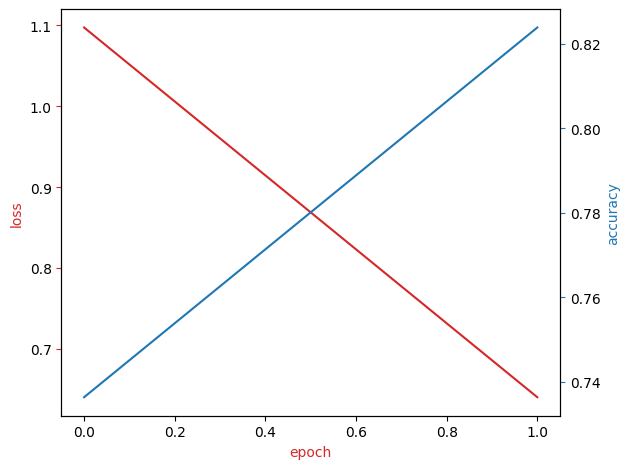

In [13]:
def plot(COST,ACC):
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(COST, color=color)
    ax1.set_xlabel('epoch', color=color)
    ax1.set_ylabel('loss', color=color)
    ax1.tick_params(axis='y', color=color)
    
    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color=color)  # you already handled the x-label with ax1
    ax2.plot(ACC, color=color)
    ax2.tick_params(axis='y', color=color)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    
    plt.show()

plot(cum_loss_list, acc_epoch)


In [14]:
def predict(text):
    with torch.no_grad():
        text = torch.tensor(vocab(tokenizer(text)))
        output = model(text, torch.tensor([0]))
        return ag_news_label[output.argmax(dim = 1).item() + 1]

real_text = [
    "International talks have made significant headway with the signing of a climate accord that commits countries to reduce emissions by 40% over the next two decades. World leaders expressed optimism at the conclusion of the summit.",
    "In a stunning upset, the underdog team won the national title, beating the favorites in a match that featured an incredible comeback and a last-minute goal that sealed their victory in front of a record crowd.",
    "Market analysts are optimistic as the tech startup's stock prices soared after the announcement of their latest product, which promises to revolutionize how we interact with smart devices.",
    "A recent study published in a leading scientific journal suggests that a new drug has shown promise in the treatment of Alzheimer's disease, outperforming current leading medications in early clinical trials.",
    "Diplomatic relations have taken a positive turn with the recent peace talks that aim to end decades of conflict. The ceasefire agreement has been welcomed by the international community.",
    "Economic indicators show a sharp rebound in manufacturing, with the automobile industry leading the charge. Analysts predict this surge will result in significant job creation over the next year.",
    "Researchers at the university's astrophysics department have discovered a potentially habitable exoplanet. The planet, which lies in a nearby star system, has conditions that could support liquid water and, possibly, life.",
    "The sports world is in shock as a legendary player announces their retirement. Over an illustrious 20-year career, the athlete has amassed numerous records and is regarded as one of the greatest to ever play the game.",
    "A multinational corporation has announced a major investment in renewable energy. The initiative includes the construction of new wind farms and solar panels that will power hundreds of thousands of homes.",
    "Climate scientists warn that the melting of the polar ice caps has been accelerating at an alarming rate, raising sea levels and threatening coastal cities worldwide with increased flooding risks."
]

predict(real_text[5])

'Sports'

### Embedding analysis

In [15]:
# Get the first batch from the validation data
batch = next(iter(valid_loader))

# Extract the text and offsets from the batch
label, text, offsets = batch

# Send the data to the device (GPU if available)
text = text.to(device)
offsets = offsets.to(device)

# Get the embeddings bag output for the batch
embedded = model.embedding(text, offsets)

# Convert the embeddings tensor to a numpy array
embeddings_numpy = embedded.detach().cpu().numpy()

# Perform t-SNE on the embeddings to reduce their dimensionality to 3D.
X_embedded_3d = TSNE(n_components=3).fit_transform(embeddings_numpy)

# Create a 3D scatter plot using Plotly
trace = go.Scatter3d(
    x=X_embedded_3d[:, 0],
    y=X_embedded_3d[:, 1],
    z=X_embedded_3d[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color=label.numpy(),  # Use label information for color
        colorscale='Viridis',  # Choose a colorscale
        opacity=0.8
    )
)

layout = go.Layout(title="3D t-SNE Visualization of Embeddings",
                   scene=dict(xaxis_title='Dimension 1',
                              yaxis_title='Dimension 2',
                              zaxis_title='Dimension 3'))

fig = go.Figure(data=[trace], layout=layout)
fig.show()

## Using pretrained GloVe

### Idea

GloVe, on the other hand, is another popular algorithm for learning word embeddings. It stands for Global Vectors for Word Representation. Unlike word2vec, which is based on predicting context/target words, GloVe focuses on capturing the global word co-occurrence statistics from the entire corpus. It constructs a co-occurrence matrix that represents how often words appear together in the text. The matrix is then factorized to obtain the word embeddings. For example, if "Man" and "King" co-occure many times, their vectors will be simialr.

The GloVe model follows a fundamental approach by constructing a large word-context co-occurrence matrix that contains pairs of (word, context). Each entry in this matrix represents the frequency of a word occurring within a given context, which can be a sequence of words. The objective of the model is to utilize matrix factorization techniques to approximate this co-occurrence matrix. The process is illustrated in the following diagram:

1. Create a word-context co-occurrence matrix: The model begins by generating a matrix that captures the co-occurrence information of words and their surrounding contexts. Each element in the matrix represents how often a specific word and context pair co-occur in the training data.

2. Apply matrix factorization: Next, the GloVe model applies matrix factorization methods to approximate the word-context co-occurrence matrix. The goal is to decompose the original matrix into lower-dimensional representations that capture the semantic relationships between words and contexts.

3. Obtain word and context embeddings: By factorizing the co-occurrence matrix, the model obtains word and context embeddings. These embeddings are numerical representations that encode the semantic meaning and relationships of words and contexts.

To accomplish this, you can usually begin by initializing WF (Word-Feature matrix) and FC (Feature-Context matrix) with random weights.You will then perform a multiplication operation between these matrices to obtain WC' (an approximation of WC), and assess its similarity to WC. This process is repeated multiple times using Stochastic Gradient Descent (SGD) to minimize the error(WC'-WC).

Once the training is complete, the resulting Word-Feature matrix (WF) provides you with word embeddings or vector representations for each word(the green vector in the diagram). The dimensionality of the embedding vectors can be predetermined by setting the value of F to a specific number of dimensions, allowing for a compact representation of the word semantics.

<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-AI0205EN-SkillsNetwork/matrix%20fact.png" alt="Co-occurence matrix" class="bg-primary" width="600px">

The key advantage of GloVe is that it can incorporate both global statistics and local context information. This results in word embeddings that not only capture the semantic relationships between words but also preserve certain syntactic relationships.

### Download and see similarities in embedding

In [16]:
from torchtext.vocab import GloVe, vocab #*Glo*bal *Ve*ctors representation from Standford NLP group

glove_vectors_6B = GloVe(name='6B', dim = 50, cache = './GloVe_model/') #6B is not the number of parameters, 
                                                                        #but the number of tokens used for training
                                                                        #dim = embedding dimension


vocab = vocab(glove_vectors_6B.stoi,0, specials = ('<unk>', '<pad>'))
vocab.set_default_index(vocab['<unk>'])

word_to_index = glove_vectors_6B.stoi  # without the special tokens

embeddings_Glove6B = torch.nn.Embedding.from_pretrained(glove_vectors_6B.vectors,freeze=True)
embeddings_Glove6B.weight[vocab['team']] #dim = 50, the embedding of the word 'team'


tensor([ 0.2501, -0.0340,  0.0941,  0.3234, -0.0165, -0.6321, -1.2778,  0.3226,
        -0.1411, -0.2900, -0.7388, -1.0599, -0.6915,  0.0670,  1.4545,  0.2447,
        -0.7986, -0.8467, -0.8100, -0.1035,  0.5937,  0.4780,  0.3372, -0.4284,
        -0.3413, -1.8441,  0.3073,  0.2960, -0.4052,  0.3416,  3.4163,  0.4477,
        -0.4327,  0.1254,  0.0556, -0.5740,  0.1810,  0.0923,  0.0726, -0.4837,
        -0.7181,  0.3952, -0.1291, -0.2552,  0.4102,  0.1954, -0.1200,  0.8398,
        -0.2912,  0.0787])

This computed the similarity between two embedded words using the cosine similarity. We check the similarity between some words (it takes 13 sec):

In [17]:
def find_similar_words(target_word, embedding_dict, top_k=2):
    if target_word not in embedding_dict:
        return f"Word '{target_word}' not found in embeddings."
    
    target_vector = embedding_dict[target_word]
    similarities = {}

    for word, vector in embedding_dict.items():
        if word == target_word:
            continue
        similarity = np.dot(target_vector, vector) / (np.linalg.norm(target_vector) * np.linalg.norm(vector))
        similarities[word] = similarity

    sorted_words = sorted(similarities.items(), key=lambda x: x[1], reverse=True)
    return [word for word, _ in sorted_words[:top_k]]

words = glove_vectors_6B.itos # all the tokens without the special tokens <pad> and <unk>

embedding_dict_Glove6B = {}
for word in words:
    # Get the index of the word from the vocabulary to access its embedding
    embedding_vector = embeddings_Glove6B.weight[word_to_index[word]]
    if embedding_vector is not None:
        embedding_dict_Glove6B[word] = embedding_vector

target_word = "team"
top_k=2
similar_words = find_similar_words(target_word, embedding_dict_Glove6B, top_k)

# Print the similar words
print("{} most similar words to {}:".format(top_k,target_word) ,similar_words)


2 most similar words to team: ['teams', 'football']


### Using it for text classification

In [18]:
from torchtext.vocab import GloVe, vocab #*Glo*bal *Ve*ctors representation from Standford NLP group

hidden_dim = 300 
glove_vectors_6B = GloVe(name='6B', dim = hidden_dim, cache = './GloVe_model/') #6B is not the number of parameters, 
                                                                        #but the number of tokens used for training
                                                                        #dim = embedding dimension

# vocab = vocab(glove_vectors_6B.stoi,0, specials = ('<unk>', '<pad>'))
# vocab.set_default_index(vocab['<unk>']) #this will bring to an error!!!

counter = Counter(glove_vectors_6B.stoi.keys())
ordered_dict = OrderedDict(counter.most_common())

# Crea vocab e aggiungi special tokens
vocab = vocab(ordered_dict)
vocab.insert_token('<unk>', 0)
vocab.insert_token('<pad>', 1)
vocab.set_default_index(vocab['<unk>'])

tokenizer = get_tokenizer("basic_english")

train_iter, test_iter = AG_NEWS()
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)

num_train = int(len(train_dataset) * 0.85)
split_train, split_valid = random_split(train_dataset, [num_train, len(train_dataset) - num_train])

ag_news_label = {1: "World", 2: "Sports", 3: "Business", 4: "Sci/Tec"}
'''ag_news_label[y]'''
num_class = len(set([label for (label, text) in train_iter ]))

Same collate as before (with the difference of the `.lower()` in `processed_text`):

In [19]:
def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for label, text in batch:

        label_list.append(int(label)-1) # convert to zero-based index

        processed_text = torch.tensor(vocab(tokenizer(text.lower())), dtype=torch.int64) #vocab(tokenizer(text) is the list of integers corresponidng to the tokens
        text_list.append(processed_text)
        
        offsets.append(len(processed_text))

    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list) #concatenate all the text tensors into a single tensor
    return label_list.to(device), text_list.to(device), offsets.to(device)

BATCH_SIZE = 64

train_loader = DataLoader(split_train, batch_size = BATCH_SIZE, shuffle = True, collate_fn = collate_batch)
valid_loader = DataLoader(split_valid, batch_size = BATCH_SIZE, shuffle = True, collate_fn = collate_batch)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = True, collate_fn = collate_batch)

Same model as before, but there is the pretrained nn and there is a difference in the forward

In [20]:
class TextClassificationModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(TextClassificationModel, self).__init__()

        embedding_matrix = torch.zeros(len(vocab), hidden_dim)
        for token, idx in vocab.get_stoi().items():
            if token in glove_vectors_6B.stoi:
                embedding_matrix[idx] = glove_vectors_6B[token]
            else:
                embedding_matrix[idx] = torch.randn(hidden_dim)  # o lascia a zero

        self.embedding = nn.EmbeddingBag.from_pretrained(embedding_matrix, freeze=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        out = self.fc(embedded)

        return out

Same accuracy as before:

In [21]:
def evaluate(dataloader, model ):
    model.eval()
    total_acc, total_count= 0, 0

    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predicted_label = model(text, offsets)

            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc / total_count

vocab_size=len(vocab)
embedding_dim = hidden_dim 

num_of_classes = num_class
model = TextClassificationModel(input_dim = vocab_size, hidden_dim = embedding_dim, output_dim = num_of_classes).to(device)

evaluate(test_loader, model)

0.23460526315789473

In [22]:
lr=0.01
epochs = 2
cum_loss_list=[]
acc_epoch=[]
acc_old=0

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 1.0, gamma = 0.1) # after 1.0 epochs, the lerning rate will be multiplied by gamma

for epoch in range(epochs):
    cum_loss = 0.0
    print(f'epoch {epoch+1}')
    model.train()
    for i, (label, text, offsets) in enumerate(tqdm(train_loader)):
        
        optimizer.zero_grad()
        predicted_label = model(text, offsets)
        loss = criterion(predicted_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1) #gradient clipping
        optimizer.step()
        cum_loss += loss.item()
    
    cum_loss_list.append(cum_loss/len(train_loader))
    accu_val = evaluate(valid_loader, model)
    acc_epoch.append(accu_val)

    if accu_val > acc_old:
      acc_old= accu_val
      torch.save(model.state_dict(), 'my_model.pth')


epoch 1


  0%|          | 0/1594 [00:00<?, ?it/s]

epoch 2


  0%|          | 0/1594 [00:00<?, ?it/s]

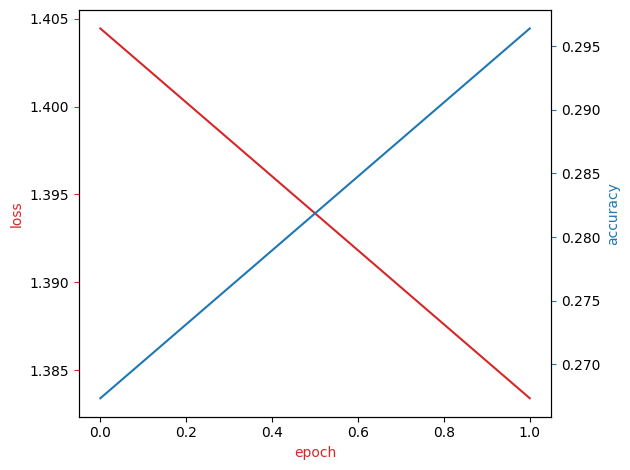

In [23]:
def plot(COST,ACC):
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(COST, color=color)
    ax1.set_xlabel('epoch', color=color)
    ax1.set_ylabel('loss', color=color)
    ax1.tick_params(axis='y', color=color)
    
    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color=color)  # you already handled the x-label with ax1
    ax2.plot(ACC, color=color)
    ax2.tick_params(axis='y', color=color)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    
    plt.show()

plot(cum_loss_list, acc_epoch)

# 3) N-Gram model

## General and idea

The idea is to compute:

- **Bi-gram**: $$P(\text{word}_{i+1} \mid \text{word}_{i})= \frac{\text{count}(\text{word}_{i}\text{word}_{i+1})}{\text{total count of}(\text{word}_{i})}\,, \quad \widehat{\text{word}}_{i+1} = \arg\max_{\text{word}_{i+1}} P(\text{word}_{i+1} \mid  \text{word}_{i})$$ where $\text{word}_{i}$ is the context, and the `context_size = 1`, because we only consider the previous word.
- **Tri-gram**: $P(\text{word}_{i+2} \mid \text{word}_{i+1}, \text{word}_{i})$→ `context_size = 2`. Then:  $\widehat{\text{word}}_{i+2} = \arg\max_{\text{word}_{i+2}} P(\text{word}_{i+2} \mid \text{word}_{i+1}, \text{word}_{i})$

To do this we need frequencies, in the sense that the conditioned probability is computed by using **frequency of occurrence/total number of words**.


For large $N$-grams, this becomes computationally complex due to data sparsity and memory usage. To overcome this, we can use **neural networks to approximate** the probability distribution:

- The **input dimension** is: $\text{dim\_voc} \times (N - 1)$ where the context vector is defined as the **concatenation of the one-hot encodings** (or embeddings) of the previous $N-1$ words.
  
  - If using **one-hot encoding**: it means concatenating $(N-1)$ one-hot vectors of size $\text{dim\_voc}$.
  - More commonly, we use **embedding vectors** (e.g. via `nn.Embedding`) of dimension $d$, so the input becomes a concatenation of $(N-1)$ vectors in $\mathbb{R}^d$, i.e. $\text{Input size} = d \times (N - 1)$.

- The **output dimension** is $\text{dim\_voc}$, because we want to **predict a word** within the vocabulary — i.e., a classification problem.


One should pay attention to this:
- If we build the tokens using **word_tokenize**, then it is better not to use the methods **build_vocab_from_iterator** of torchtext, which is built to work well with **get_tokenizer**. This last approach is useful for neural networks, so if we instead build standard N-gram, we can use nltk for preprocess the text (see below).

Summarizing, we define a function to preprocess strings
```
def preprocess_string(s):
    s = re.sub(r"[^\w\s]", '', s) # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"\s+", '', s) # Replace all runs of whitespaces with no space
    s = re.sub(r"\d", '', s) # replace digits with no space
    return s
```
and then:
1. **Standard N-grams**:  use 
```
def preprocess(words):
    tokens = word_tokenize(words)
    tokens = [preprocess_string(w)   for w in tokens]
    return [w.lower()  for w in tokens if len(w)!=0 or not(w in string.punctuation) ]

tokens = preprocess(song)
vocabulary = set(tokens)
```
2. **Neural Networks**: use 
```
tokenizer = get_tokenizer("basic_english")

def preprocess(words):
    tokens = tokenizer(words)
    tokens = [preprocess_string(w)   for w in tokens]
    return [w.lower()  for w in tokens if len(w)!=0 or not(w in string.punctuation) ]

def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

tokens = preprocess(song)
vocabulary = build_vocab_from_iterator(yield_tokens(song), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])
``` 

Really, the tokenizer from torchtext is usually sufficient, whilst our preprocess_string() is quite aggressive, since it removes all the punctuation and white spaces. So, typically one uses (for nn):
```
tokenizer = get_tokenizer("basic_english")
tokens = tokenizer(song)

def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

tokens = preprocess(song)
vocabulary = build_vocab_from_iterator(yield_tokens(song), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])
``` 



In [24]:
def preprocess_string(s):
    s = re.sub(r"[^\w\s]", '', s) # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"\s+", '', s) # Replace all runs of whitespaces with no space
    s = re.sub(r"\d", '', s) # replace digits with no space
    return s

def preprocess(words):
    tokens = word_tokenize(words)
    tokens = [preprocess_string(w)   for w in tokens]
    return [w.lower()  for w in tokens if len(w)!=0 or not(w in string.punctuation) ]

## Using Frequency

The dataset:

In [25]:
song= """We are no strangers to love
You know the rules and so do I
A full commitments what Im thinking of
You wouldnt get this from any other guy
I just wanna tell you how Im feeling
Gotta make you understand
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Weve known each other for so long
Your hearts been aching but youre too shy to say it
Inside we both know whats been going on
We know the game and were gonna play it
And if you ask me how Im feeling
Dont tell me youre too blind to see
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Weve known each other for so long
Your hearts been aching but youre too shy to say it
Inside we both know whats been going on
We know the game and were gonna play it
I just wanna tell you how Im feeling
Gotta make you understand
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you"""

In [26]:
tokens = preprocess(song)
print(tokens[:6])
vocabulary = set(tokens)

fdist = nltk.FreqDist(tokens) #function from nltk to count the frequency of each tokem, dict{'word': frequency}

total_number_of_words = sum(fdist.values()) # == len(tokens)

non_cond_probability = {}
for token in tokens:
    non_cond_probability[token] = fdist[token]/total_number_of_words

['we', 'are', 'no', 'strangers', 'to', 'love']


A uni-gram model would have used non_cond_probability to predict the next word, predicting basically each time the word with the max probability (useless!)

This make_predictions function works for every N-gram:

In [27]:
def make_predictions(my_words, freq_grams, normlize=1, vocabulary = vocabulary):
    """
    Generate predictions for the conditional probability of the next word given a sequence.

    Args:
        my_words (list): A list of words in the input sequence.
        freq_grams (dict): A dictionary containing frequency of n-grams.
        normlize (int): A normalization factor for calculating probabilities.
        vocabulary (list): A list of words in the vocabulary.

    Returns:
        list: A list of predicted words along with their probabilities, sorted in descending order.
    """

    vocab_probabilities = {}  # Initialize a dictionary to store predicted word probabilities

    context_size = len(list(freq_grams.keys())[0])  # Determine the context size from n-grams keys

    # Preprocess input words and take only the relevant context words
    my_tokens = preprocess(my_words)[0:context_size - 1]

    # Calculate probabilities for each word in the vocabulary given the context
    for next_word in vocabulary:
        temp = my_tokens.copy()
        temp.append(next_word)  # Add the next word to the context

        # Calculate the conditional probability using the frequency information
        if normlize!=0:
            vocab_probabilities[next_word] = freq_grams[tuple(temp)] / normlize
        else:
            vocab_probabilities[next_word] = freq_grams[tuple(temp)] 
    # Sort the predicted words based on their probabilities in descending order
    vocab_probabilities = sorted(vocab_probabilities.items(), key=lambda x: x[1], reverse=True)

    return vocab_probabilities

### Bi-gram and Tri-gram

In [28]:
bigrams = nltk.bigrams(tokens) # this is an iterator
my_bigrams = list(bigrams) # list of tuples, each tuple is a bigram (word1,word2)
print(my_bigrams[0:2])

bigrams = nltk.bigrams(tokens) # again to reset the iterator
freq_bigrams  = nltk.FreqDist(bigrams)

my_song = "i"
for i in range(100):
    next_word = make_predictions(my_song.split()[-1], freq_bigrams, fdist[my_song.split()[-1]], list(fdist))
    my_song += " " + next_word[0][0]
print(my_song)

trigrams = nltk.trigrams(tokens) # again to reset the iterator
freq_tigrams  = nltk.FreqDist(trigrams)

my_song = "i just"
for i in range(100):
    context = my_song.split()[-2:]
    normlize = freq_bigrams[tuple(context)]  # Frequenza del contesto
    next_word = make_predictions(" ".join(context), freq_tigrams, normlize, list(fdist))
    my_song += " " + next_word[0][0]
print(my_song)


[('we', 'are'), ('are', 'no')]
i just wan na tell a lie and desert you never gon na tell a lie and desert you never gon na tell a lie and desert you never gon na tell a lie and desert you never gon na tell a lie and desert you never gon na tell a lie and desert you never gon na tell a lie and desert you never gon na tell a lie and desert you never gon na tell a lie and desert you never gon na tell a lie and desert you never gon na tell a lie and desert you never
i just wan na tell a lie and hurt you never gon na tell a lie and hurt you never gon na tell a lie and hurt you never gon na tell a lie and hurt you never gon na tell a lie and hurt you never gon na tell a lie and hurt you never gon na tell a lie and hurt you never gon na tell a lie and hurt you never gon na tell a lie and hurt you never gon na tell a lie and hurt you never gon na tell a lie and hurt you never gon


## Using a nn

The dataset:

In [29]:
song = """We are no strangers to love
You know the rules and so do I
A full commitments what Im thinking of
You wouldnt get this from any other guy
I just wanna tell you how Im feeling
Gotta make you understand
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Weve known each other for so long
Your hearts been aching but youre too shy to say it
Inside we both know whats been going on
We know the game and were gonna play it
And if you ask me how Im feeling
Dont tell me youre too blind to see
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Weve known each other for so long
Your hearts been aching but youre too shy to say it
Inside we both know whats been going on
We know the game and were gonna play it
I just wanna tell you how Im feeling
Gotta make you understand
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you"""

Hyperparameters:

In [30]:
BATCH_SIZE = 10    # Number of samples per training batch
EMBEDDING_DIM = 10 # Dimension of the word embeddings
EPOCHS = 1
LR = 0.01

Basics. build the tokens, the vocabulary and a function to translate new text into indices:

In [31]:
tokenizer = get_tokenizer("basic_english")
tokens = tokenizer(song)
# use yields_token to create a vocabulary, stronger choice wrt to map(tokenizer,song). Modified the function because we do not have a label in the song
def yield_tokens(data_iter):
    for text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens([song]), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

def text_pipeline(text):
    return vocab(tokenizer(text))

Moreover we have to make the padding, otherwise the bathces could have different lenght (in particular the last one!). In this way we keep the full song, but if we are ok with eliminate the last batch instead, we can use **drop_last = True** in the DataLoader!

In [32]:
Padding = BATCH_SIZE-len(tokens)%BATCH_SIZE
tokens_pad = tokens + ["<pad>"] * Padding
vocab.append_token("<pad>") 

## Create the loader and collate function

The collate function will have to construct pair of (context, target), according to the value of N(-grams). Before construct the collate_fn, let's build these pairs explicitly for educational purposes:

In [33]:
def genngrams(tokens, N = 3):
    CONTEXT_SIZE = N-1
    ngrams = [
        (
            [tokens[i - j - 1] for j in range(CONTEXT_SIZE)],  # Context words (previous words)
            tokens[i]  # Target word (the word to predict)
        )
        for i in range(CONTEXT_SIZE, len(tokens))
    ]
    return ngrams

trigram = genngrams(tokens, N = 3)
print(trigram[0:3],'\n')

context, target = trigram[0]
print("context: ",context,"and target:",target)
print("context index",vocab(context),"target index",vocab([target]))


[(['are', 'we'], 'no'), (['no', 'are'], 'strangers'), (['strangers', 'no'], 'to')] 

context:  ['are', 'we'] and target: no
context index [58, 21] target index [70]


Now we build the collate function, which does the same but returns target and context separately for each gram (directly as indices):

In [34]:
CONTEXT_SIZE = 2

def collate_batch(batch):
    batch_size = len(batch)  # Get the size of the batch
    context, target = [], [] # Initialize lists for context and target words

    # Loop through the batch, ensuring enough previous words exist for context
    for i in range(CONTEXT_SIZE, batch_size):
        # Convert the target word to its index using the vocabulary
        target.append(vocab([batch[i]]))

        # Convert the previous CONTEXT_SIZE words to indices using the vocabulary
        context.append(vocab([batch[i - j - 1] for j in range(CONTEXT_SIZE)]))

    return torch.tensor(context).to(device), torch.tensor(target).to(device).reshape(-1) #from tensor([ID]) to tensor(ID)

context, target = collate_batch(tokens)
print(context[0], target[0]) #These are the same results as before

tensor([58, 21]) tensor(70)


We are ready for the loader. We pass the pad_tokens, and for this we set drop_last = False. Shuffle = False because we want to keep the ordering!

In [35]:
dataloader = DataLoader(tokens_pad, batch_size = BATCH_SIZE, shuffle = False, collate_fn = collate_batch, drop_last = False)

Since we will want to change the hyperparameter CONTEXT_SIZE in future without running again the code, we define:

In [36]:
def get_collate_fn(context_size):
    def collate_batch(batch):
        batch_size = len(batch)
        context, target = [], []
        for i in range(context_size, batch_size):
            target.append(vocab([batch[i]]))
            context.append(vocab([batch[i - j - 1] for j in range(context_size)]))
        return torch.tensor(context).to(device), torch.tensor(target).to(device).reshape(-1)
    return collate_batch

CONTEXT_SIZE = 2
collate_batch = get_collate_fn(CONTEXT_SIZE)
dataloader = DataLoader(tokens_pad, batch_size = BATCH_SIZE, shuffle = False, collate_fn = collate_batch, drop_last = False)

## Model

In [37]:
class NGramLanguageModeler(nn.Module):
    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NGramLanguageModeler, self).__init__()

        self.context_size = context_size
        self.embedding_dim = embedding_dim
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, context): #the input is the context!!!

        embeddings = self.embeddings(context)  # Shape: (batch_size, context_size, embedding_dim)
        flattened = torch.reshape(embeddings, (-1, self.context_size * self.embedding_dim))  # Reshape the embeddings into a single vector per input sample
        # New shape: (batch_size, embedding_dim * context_size = embedding_dim * (N-1))
        out = nn.functional.relu(self.linear1(flattened))  # Shape: (batch_size, 128)
        out = self.linear2(out)  # Shape: (batch_size, vocab_size)

        return out
    


## Training the model

In [38]:
criterion = torch.nn.CrossEntropyLoss()
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 1.0, gamma = 0.1) # after 1.0 epochs, the lerning rate will be multiplied by gamma

def train(dataloader, model, optimizer, number_of_epochs = 1):
    LOSS = [] 
    for epoch in tqdm(range(number_of_epochs)):
        total_loss = 0.0
        for context, target in dataloader:

            model.zero_grad()         
            predicted = model(context)  
            loss = criterion(predicted, target)  
            total_loss += loss.item() 

            loss.backward() 
            optimizer.step()   

        LOSS.append(total_loss/len(dataloader))  

    return LOSS 

CONTEXT_SIZE = 2
collate_batch = get_collate_fn(CONTEXT_SIZE)
dataloader = DataLoader( tokens_pad, batch_size = BATCH_SIZE, shuffle = False, collate_fn = collate_batch, drop_last = False)
model_2 = NGramLanguageModeler(vocab_size = len(vocab), embedding_dim = EMBEDDING_DIM, context_size = CONTEXT_SIZE).to(device)
optimizer_2 = torch.optim.SGD(model_2.parameters(), lr = LR)
loss_2 = train(dataloader = dataloader, model = model_2, optimizer = optimizer_2, number_of_epochs = EPOCHS)
save_path = '3gram.pth'
torch.save(model_2.state_dict(), save_path)

CONTEXT_SIZE = 4
collate_batch = get_collate_fn(CONTEXT_SIZE)
dataloader = DataLoader( tokens_pad, batch_size = BATCH_SIZE, shuffle = False, collate_fn = collate_batch, drop_last = False)
model_4 = NGramLanguageModeler(vocab_size = len(vocab), embedding_dim = EMBEDDING_DIM, context_size = CONTEXT_SIZE).to(device)
optimizer_4 = torch.optim.SGD(model_4.parameters(), lr = LR)
loss_4 = train(dataloader = dataloader, model = model_4, optimizer = optimizer_4, number_of_epochs = EPOCHS)
save_path = '5gram.pth'
torch.save(model_4.state_dict(), save_path)

CONTEXT_SIZE = 8
collate_batch = get_collate_fn(CONTEXT_SIZE)
dataloader = DataLoader( tokens_pad, batch_size = BATCH_SIZE, shuffle = False, collate_fn = collate_batch, drop_last = False)
model_8 = NGramLanguageModeler(vocab_size = len(vocab), embedding_dim = EMBEDDING_DIM, context_size = CONTEXT_SIZE).to(device)
optimizer_8 = torch.optim.SGD(model_8.parameters(), lr = LR)
loss_8 = train(dataloader = dataloader, model = model_8, optimizer = optimizer_8, number_of_epochs = EPOCHS)
save_path = '9gram.pth'
torch.save(model_8.state_dict(), save_path)

losses_list = [loss_2, loss_4, loss_8]



  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

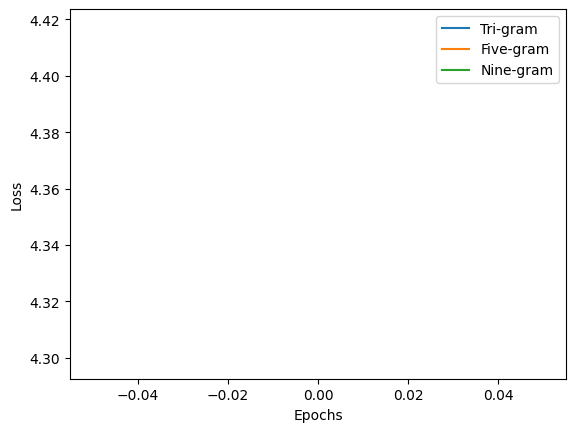

In [39]:
plt.plot(loss_2)
plt.plot(loss_4)
plt.plot(loss_8)
plt.legend(["Tri-gram","Five-gram","Nine-gram"])
plt.xlabel("Epochs")
plt.ylabel('Loss')
plt.show()
plt.close()

## Inference - Text generation

Function for generating songs:

In [40]:
def write_song(model, my_song, number_of_words = 100, context_size = 2):
    index_to_token = vocab.get_itos() # list of token and vocabulary IDs

    for i in range(number_of_words):

        with torch.no_grad():  # Disable gradient computation for inference
            
            # Prepare the input context by extracting the last CONTEXT_SIZE words from tokens
            context = torch.tensor(
                vocab([tokens[i - j - 1] for j in range(context_size)])
            ).to(device)  
            
            # Predict the next word by selecting the word with the highest probability
            word_idx = torch.argmax(model(context))  # Get index of the most likely next word
            
            # Append the predicted word to the generated text
            my_song += " " + index_to_token[word_idx.detach().item()]

    return my_song

In [41]:
model_8.load_state_dict(torch.load('9gram.pth'))
model_8.eval()
write_song(model_8, 'I love my', number_of_words = 30, context_size = 8)

'I love my never no dont for say say gonna commitments commitments it do say it it say commitments gonna strangers strangers it commitments gotta get commitments it say never dont dont feeling'

## Embedding Analysis

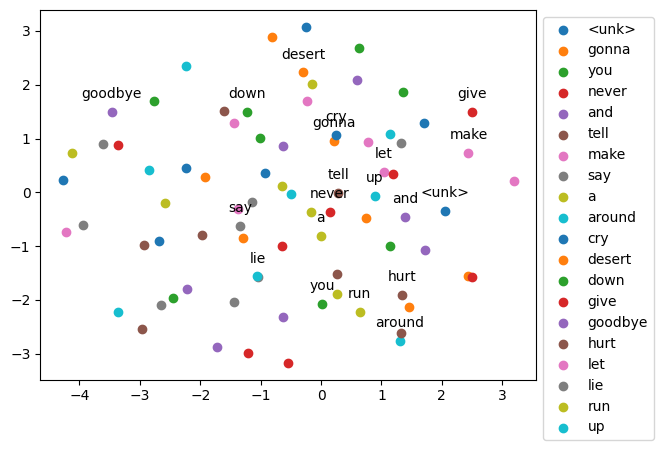

In [42]:
X = model_8.embeddings.weight.cpu().detach().numpy()
tsne = TSNE(n_components=2, random_state=42)
X_2d = tsne.fit_transform(X)

labels = []

for j in range(len(X_2d)):
    if j < 20:
        plt.scatter(X_2d[j, 0], X_2d[j, 1], label=vocab.get_itos()[j])
        labels.append(vocab.get_itos()[j])
        # Add words as annotations
        plt.annotate(vocab.get_itos()[j],
                     (X_2d[j, 0], X_2d[j, 1]),
                     textcoords="offset points",
                     xytext=(0, 10),
                     ha='center')
    else:
        plt.scatter(X_2d[j, 0], X_2d[j, 1])

plt.legend(labels, loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

# 4) Word2vec model with CBOW (continuous Bag-of-words) and Skip-gram

These models are very similar to the nn approach of N-grams, the key difference is that:
- **N-gram** : given a target $i$, it uses the preceeding $N-1$ words to predict the $i-th$ one;
- **Word-to-vec** : 
    1. **CBOW**: given a target $i$, it uses the preceeding $n$ and successive $n$ words (which are the context) to predict the $i-th$ one. It uses a BOW, so the input dimension of the nn, this time, is $D=$dimension of vocabulary. In practice, as usual, one uses the token indices, so the BOW is not done using the OHE. In the CBOW introduced by (Mikolov et al., 2013), the order of the context is not important, and so we will use a **nn.EmbeddingBag**
    2. **Skip-gram**: predicts the same context, using the target (it is the opposite!). In this case, the embedding dimension is usally greater than the vocab size!  The idea is that words that appear in similar contexts tend to have similar meanings


When selecting CBOW or Skip-Gram, the best approach often depends on the specifics of your task and data. If your dataset is small but you need to have a good representation of rarer words, Skip-gram might be the better choice. If the computational efficiency is more critical and the rare words are less of a concern, CBOW might be adequate. It's also worth noting that for very small datasets, the benefits of neural word embeddings might be limited, and simpler methods or leveraging pretrained embeddings might be more effective.


The dataset:

In [43]:
toy_data = """I wish I was little bit taller
I wish I was a baller
She wore a small black dress to the party
The dog chased a big red ball in the park
He had a huge smile on his face when he won the race
The tiny kitten played with a fluffy toy mouse
The team celebrated their victory with a grand parade
She bought a small, delicate necklace for her sister
The mountain peak stood majestic and tall against the clear blue sky
The toddler took small, careful steps as she learned to walk
The house had a spacious backyard with a big swimming pool
He felt a sense of accomplishment after completing the challenging puzzle
The chef prepared a delicious, flavorful dish using fresh ingredients
The children played happily in the small, cozy room
The book had an enormous impact on readers around the world
The wind blew gently, rustling the leaves of the tall trees
She painted a beautiful, intricate design on the small canvas
The concert hall was filled with thousands of excited fans
The garden was adorned with colorful flowers of all sizes
I hope to achieve great success in my chosen career path
The skyscraper towered above the city, casting a long shadow
He gazed in awe at the breathtaking view from the mountaintop
The artist created a stunning masterpiece with bold brushstrokes
The baby took her first steps, a small milestone that brought joy to her parents
The team put in a tremendous amount of effort to win the championship
The sun set behind the horizon, painting the sky in vibrant colors
The professor gave a fascinating lecture on the history of ancient civilizations
The house was filled with laughter and the sound of children playing
She received a warm, enthusiastic welcome from the audience
The marathon runner had incredible endurance and determination
The child's eyes sparkled with excitement upon opening the gift
The ship sailed across the vast ocean, guided by the stars
The company achieved remarkable growth in a short period of time
The team worked together harmoniously to complete the project
The puppy wagged its tail, expressing its happiness and affection
She wore a stunning gown that made her feel like a princess
The building had a grand entrance with towering columns
The concert was a roaring success, with the crowd cheering and clapping
The baby took a tiny bite of the sweet, juicy fruit
The athlete broke a new record, achieving a significant milestone in her career
The sculpture was a masterpiece of intricate details and craftsmanship
The forest was filled with towering trees, creating a sense of serenity
The children built a small sandcastle on the beach, their imaginations running wild
The mountain range stretched as far as the eye could see, majestic and awe-inspiring
The artist's brush glided smoothly across the canvas, creating a beautiful painting
She received a small token of appreciation for her hard work and dedication
The orchestra played a magnificent symphony that moved the audience to tears
The flower bloomed in vibrant colors, attracting butterflies and bees
The team celebrated their victory with a big, extravagant party
The child's laughter echoed through the small room, filling it with joy
The sunflower stood tall, reaching for the sky with its bright yellow petals
The city skyline was dominated by tall buildings and skyscrapers
The cake was adorned with a beautiful, elaborate design for the special occasion
The storm brought heavy rain and strong winds, causing widespread damage
The small boat sailed peacefully on the calm, glassy lake
The artist used bold strokes of color to create a striking and vivid painting
The couple shared a passionate kiss under the starry night sky
The mountain climber reached the summit after a long and arduous journey
The child's eyes widened in amazement as the magician performed his tricks
The garden was filled with the sweet fragrance of blooming flowers
The basketball player made a big jump and scored a spectacular slam dunk
The cat pounced on a small mouse, displaying its hunting instincts
The mansion had a grand entrance with a sweeping staircase and chandeliers
The raindrops fell gently, creating a rhythmic patter on the roof
The baby took a big step forward, encouraged by her parents' applause
The actor delivered a powerful and emotional performance on stage
The butterfly fluttered its delicate wings, mesmerizing those who watched
The company launched a small-scale advertising campaign to test the market
The building was constructed with strong, sturdy materials to withstand earthquakes
The singer's voice was powerful and resonated throughout the concert hall
The child built a massive sandcastle with towers, moats, and bridges
The garden was teeming with a variety of small insects and buzzing bees
The athlete's muscles were well-developed and strong from years of training
The sun cast long shadows as it set behind the mountains
The couple exchanged heartfelt vows in a beautiful, intimate ceremony
The dog wagged its tail vigorously, a sign of excitement and happiness
The baby let out a tiny giggle, bringing joy to everyone around"""

In [44]:
tokenizer = get_tokenizer("basic_english")
tokens = tokenizer(toy_data)
# use yields_token to create a vocabulary, stronger choice wrt to map(tokenizer,song). Modified the function because we do not have a label in the song
def yield_tokens(data_iter):
    for text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens([toy_data]), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

def text_pipeline(text):
    return vocab(tokenizer(text))

Training functions, used both in CBOW and skip-gram: 

In [45]:
def train(dataloader, model, optimizer, criterion, number_of_epochs = 1):
    LOSS = [] 
    for epoch in tqdm(range(number_of_epochs)):
        total_loss = 0.0
        for idx, samples in enumerate(dataloader):

            model.zero_grad()         
            # Check for EmbeddingBag layer in the model, used in the CBOW model
            if any(isinstance(module, nn.EmbeddingBag) for _, module in model.named_modules()):
                target, context, offsets = samples
                predicted = model(context, offsets)
            
            # Check for Embedding layer in the model
            elif any(isinstance(module, nn.Embedding) for _, module in model.named_modules()):
                target, context = samples
                predicted = model(context)

            loss = criterion(predicted, target)  
            total_loss += loss.item() 

            loss.backward() 
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
            optimizer.step()   

        LOSS.append(total_loss/len(dataloader))  

    return LOSS 

## CBOW

In [46]:
tokens[0:10]

['i', 'wish', 'i', 'was', 'little', 'bit', 'taller', 'i', 'wish', 'i']

The following is similar to the N-gram, again for educational purposes:

In [47]:
CONTEXT_SIZE = 2 #we look to CONTEXT_SIZE words before and CONTEXT_SIZE words after the target word
cbow_data = []

for i in range(CONTEXT_SIZE, len(tokens) - CONTEXT_SIZE):

    context = (
        [tokens [i - CONTEXT_SIZE + j] for j in range(CONTEXT_SIZE)]
        + [tokens [i + j + 1] for j in range(CONTEXT_SIZE)]
    )

    target = tokens [i]

    cbow_data.append((context, target))

cbow_data[0:2]

[(['i', 'wish', 'was', 'little'], 'i'),
 (['wish', 'i', 'little', 'bit'], 'was')]

Now we build the collate function, which does the same but return target, context and offsets separately:

In [48]:
def collate_batch(batch):
    target_list, context_list, offsets = [], [], [0]
    for _context, _target in batch:
        
        target_list.append(vocab[_target])  
        processed_context = torch.tensor(text_pipeline(' '.join(_context)), dtype=torch.int64)
        context_list.append(processed_context)
        offsets.append(processed_context.size(0))
    target_list = torch.tensor(target_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    context_list = torch.cat(context_list)
    return target_list.to(device), context_list.to(device), offsets.to(device)

In [49]:
BATCH_SIZE = 64  # batch size for training

dataloader_cbow = DataLoader(
    cbow_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)

In [50]:
class CBOW(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        
        super(CBOW, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=False)
        self.linear1 = nn.Linear(embed_dim, embed_dim//2)
        self.fc = nn.Linear(embed_dim//2, vocab_size)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()
        
    def forward(self, text, offsets):
        out = self.embedding(text, offsets)
        out = torch.relu(self.linear1(out))
        return self.fc(out)

vocab_size = len(vocab)
emsize = 24
model_cbow = CBOW(vocab_size, emsize, vocab_size).to(device)

In [51]:
LR = 5 
criterion = torch.nn.CrossEntropyLoss() 
optimizer = torch.optim.SGD(model_cbow.parameters(), lr = LR)

loss = train(dataloader = dataloader_cbow, model = model_cbow, optimizer = optimizer, criterion = criterion, number_of_epochs = 400)

  0%|          | 0/400 [00:00<?, ?it/s]

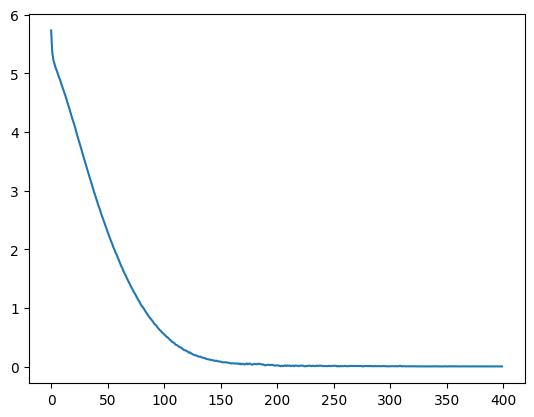

In [52]:
plt.plot(loss)

## Skip-gram

In [53]:
CONTEXT_SIZE = 2
skip_data = []

for i in range(CONTEXT_SIZE, len(tokens) - CONTEXT_SIZE):

    context = (
        [tokens[i - j - 1] for j in range(CONTEXT_SIZE)]  # Preceding words
        + [tokens[i + j + 1] for j in range(CONTEXT_SIZE)]  # Succeeding words
    )
    target = tokens[i]
    skip_data.append((target, context))

print('Tokens:',tokens[0:10])
print('CBOW:',cbow_data[0:2])
print('Skip:',skip_data[0:2]) # opposite of CBOW


skip_data_flat = [(target, context_word) for target, context in skip_data for context_word in context] # flatten the list of tuples into a single list, for the nn.EmbeddingBag
      
print(skip_data_flat[0:4])

Tokens: ['i', 'wish', 'i', 'was', 'little', 'bit', 'taller', 'i', 'wish', 'i']
CBOW: [(['i', 'wish', 'was', 'little'], 'i'), (['wish', 'i', 'little', 'bit'], 'was')]
Skip: [('i', ['wish', 'i', 'was', 'little']), ('was', ['i', 'wish', 'little', 'bit'])]
[('i', 'wish'), ('i', 'i'), ('i', 'was'), ('i', 'little')]


In [54]:
def collate_fn(batch):
    target_list, context_list = [], []
    for _context, _target in batch:
        
        target_list.append(vocab[_target]) 
        context_list.append(vocab[_context])
        
    target_list = torch.tensor(target_list, dtype=torch.int64)
    context_list = torch.tensor(context_list, dtype=torch.int64)
    return target_list.to(device), context_list.to(device)

dataloader = DataLoader(skip_data_flat, batch_size = BATCH_SIZE, collate_fn = collate_fn)


In [55]:
class SkipGram_Model(nn.Module):

    def __init__(self, vocab_size, embed_dim):
        super(SkipGram_Model, self).__init__()
        self.embeddings = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embed_dim
        )
        self.fc = nn.Linear(in_features=embed_dim, out_features=vocab_size)

    def forward(self, text):
        out = self.embeddings(text)
        out = torch.relu(out)
        out = self.fc(out)

        return out

emsize = 24
model_sg = SkipGram_Model(vocab_size, emsize).to(device)

In [56]:
LR = 5  

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_sg.parameters(), lr = LR)

loss = train(dataloader, model_sg, optimizer, criterion, number_of_epochs = 400)

  0%|          | 0/400 [00:00<?, ?it/s]

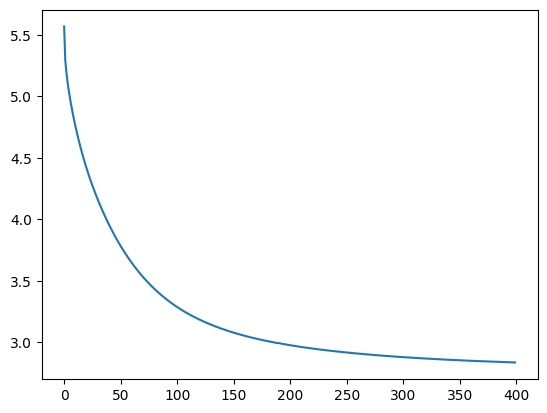

In [57]:
plt.plot(loss)
plt.show()

## Using Gensim

`vector_size` = hidden_dimension, `window` = size_of_context_window, `min_count` parameter sets the minimum frequency of a word to be included in the training process. Finally, the `workers` parameter controls the number of threads used for training.

In [58]:
# from gensim.models import Word2Vec

# sentences = [["I", "like", "to", "eat", "pizza"],
#              ["Pizza", "is", "my", "favorite", "food"],
#              ["I", "enjoy", "eating", "pasta"]]
# sentences = [[word.lower() for word in sentence] for sentence in sentences]

# w2v_model = Word2Vec(sentences, vector_size = 100, window = 3, min_count = 1, workers = 4)

# w2v_model.build_vocab(sentences, progress_per = 10000)

# w2v_model.train(sentences, total_examples = w2v_model.corpus_count, epochs = 30, report_delay = 1)

In [59]:
# similar_words = w2v_model.wv.most_similar("pizza")
# print("Similar words to 'pizza':", similar_words)

# # Calculating word similarity
# similarity = w2v_model.wv.similarity("pizza", "pasta")
# print("Similarity between 'pizza' and 'pasta':", similarity)

In [60]:
# # Extract word vectors and create word-to-index mapping
# word_vectors = w2v_model.wv
# # a dictionary to map words to their index in vocab
# word_to_index = {word: index for index, word in enumerate(word_vectors.index_to_key)}

# # Create an instance of nn.Embedding and load it with the trained vectors
# embedding_dim = w2v_model.vector_size
# embedding = torch.nn.Embedding(len(word_vectors.index_to_key), embedding_dim)
# embedding.weight.data.copy_(torch.from_numpy(word_vectors.vectors))

# # Example usage: get the embedding for a word
# word = "pizza"
# word_index = word_to_index[word]
# word_embedding = embedding(torch.LongTensor([word_index]))
# print(f"Word: {word}, Embedding: {word_embedding.detach().numpy()}")

# 5) Sequence-to-sequence model

## Idea

The aim here is for **transform a sequence into another**, and it is possibile that the first sequence has a different lenght from the second. They are used for translation, chatbots, code generation, image generation and text summarization. They overclass a problem with BOW, that is that 'the dog bites the cat' and 'the cat bites the dog' has the same BOW! Each sentence is completed with <bos> and <eos>, then are sorted by lenght (to batches the one with similar lenght), and finally we create batches, each with sentences of the same dimension (use padding). Moreover, they want to manage **input of different lenght** and **keep a global memory**, contrarily to word-to-vec and N-grams, which have a local memory. These models use:

1. RNN, where the hidden layer is used for memory, concatenating the (outputs of) input layer at time $t$ and the hidden layer at $t-1$ to connect past and future. The input layer is given as input to the next step.

RNNs have short memory and are challenging to train. Thus we use:

2. Gated RNN: 
3. LSTM:
4. Transformers


Since sequence-to-sequence may not have the same dimensions (for example a sentence $x$ in input has lenght $T_x$ and the output $y$ has $T_y$), we introduce encoder-decoder:

![Logo OpenAI](https://www.interdb.jp/dl/part03/fig-13-01.png)


Here $x^{(i)}$ is a token from the sentence $x$. The output of RNN on $x^{(1)}$, which is the hidden state $h^{(1)}$, is used as input for the next RNN and so on until the context $h^{(T_x)}$, which is the last hidden state. Notice that the outputs are not used in the encoder, whilst they are saved in the decoder part, which produces predictions one-token-per-time. Before an encoder RNN cell (blue) we can always insert an embedding layer, and bafore and after a RNN cell we can always insert an embedding and a linear layer, respectively.

# 6) Evaluation

1. **Perplexity**: $e^{\text{Cross-Entropy-Loss}}$ is used generically only on the training set. We use PyTorch.
2. **Precision(n) and Recall(n)**: given a reference translation 'The cat sits on the mat' and the trduction given by the model 'The big cat sitting on the rug' we count the number of unigram matched (4) and bigram matched (1), and this gives a measure of similarity. Then  $$ \text{Precision}_n = \frac{\text{Number of common } n\text{-grams}}{\text{Number of } n\text{-grams in the prediction}}\,,\quad  \text{Recall}_n = \frac{\text{Number of common } n\text{-grams}}{\text{Number of } n\text{-grams in the reference}}\,,\quad F_1 = \frac{2}{\frac{1}{P_n}+\frac{1}{R_n}}\,.$$
3. **ROUGE** (Recall-Oriented Understudy for Gisting Evaluation): ROUGE is a set of metrics commonly used for evaluating text summarization systems. It measures the overlap between the generated summary and one or more reference summaries. ROUGE calculates various metrics, such as ROUGE-N, which measures the n-gram overlap, and ROUGE-L, which measures the longest common subsequence. Higher ROUGE scores indicate better summarization quality.
4. **BLEU** (Bilingual Evaluation Understudy): BLEU is a metric primarily used for evaluating machine translation systems. It compares the generated translation with one or more reference translations and assigns a score based on the degree of overlap. BLEU measures the precision of the generated translation by counting the number of n-grams (contiguous sequences of n words) that appear in both the generated and reference translations. A higher BLEU score indicates a better translation quality.

Libraries for evaluation:

- NLTK with

    1. BLEU: nltk.translate.bleu_score
    2. METEOR: nltk.translate.meteor_score module

- PyTorch with perplexity and celoss
- Other libraries with

    1. BLEU: torchtext.data.metrics.bleu_score
    2. ROUGE: torchmetrics.text.rouge.ROUGEScore